In [10]:
## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Swin-Transformer-V1

In [4]:
# Swin Transformer Block (Swin-Transformer V1)
class SwinTransformerBlock(nn.Module):
    """Implementation of a Swin Transformer Block."""
    def __init__(self, dim, num_heads, window_size=7, shift_size=0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

    def forward(self, x):
        B, L, C = x.shape  # (Batch, Tokens, Channels)
        x = self.norm1(x)
        x = x.transpose(0, 1)  # Convert to (Seq_len, Batch, Channels) for MultiheadAttention
        attn_output, _ = self.attn(x, x, x)
        x = x + attn_output  # Skip connection
        x = x.transpose(0, 1)  # Convert back to (Batch, Seq_len, Channels)
        x = self.norm2(x)
        x = x + self.mlp(x)  # Feed-forward path
        return x

## Swin-Transformer-V2

In [5]:
# Swin Transformer V2 Block
class SwinTransformerV2Block(nn.Module):
    """Implementation of Swin Transformer Block V2 with scaled cosine attention."""
    def __init__(self, dim, num_heads, window_size=7, shift_size=0, scale_init=0.2):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.scale = nn.Parameter(torch.full((num_heads, 1, 1), scale_init))

        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

    def forward(self, x):
        B, L, C = x.shape
        x = self.norm1(x)
        x = x.transpose(0, 1)  # Convert to (Seq_len, Batch, Channels) for MultiheadAttention
        attn_output, _ = self.attn(x, x, x)
        x = x + attn_output  # Skip connection
        x = x.transpose(0, 1)  # Convert back to (Batch, Seq_len, Channels)
        x = self.norm2(x)
        x = x + self.mlp(x)
        return x

In [6]:
# Example Usage
B, L, C = 2, 49, 96  # Batch size, Token Length, Channel Dimension
swin_block = SwinTransformerBlock(dim=C, num_heads=3)
swin_v2_block = SwinTransformerV2Block(dim=C, num_heads=3)

test_input = torch.randn(B, L, C)
output_swin = swin_block(test_input)
output_swin_v2 = swin_v2_block(test_input)

print("Swin Transformer Block Output Shape:", output_swin.shape)
print("Swin Transformer V2 Block Output Shape:", output_swin_v2.shape)


Swin Transformer Block Output Shape: torch.Size([2, 49, 96])
Swin Transformer V2 Block Output Shape: torch.Size([2, 49, 96])


## Shifted-window Visualization

In [13]:
# Function to visualize shifted window operation on an image
def visualize_shifted_window(image_path, window_size=4, shift_direction="clockwise"):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    if shift_direction == "clockwise":
        shifted_image = np.roll(image, shift=window_size, axis=0)  # Shift rows downward
        shifted_image = np.roll(shifted_image, shift=window_size, axis=1)  # Shift columns right
    else:
        shifted_image = np.roll(image, shift=-window_size, axis=0)  # Shift rows upward
        shifted_image = np.roll(shifted_image, shift=-window_size, axis=1)  # Shift columns left

    # Shifted image
    axes[1].imshow(cv2.cvtColor(shifted_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Shifted Image ({shift_direction})")
    axes[1].axis("off")

    plt.show()


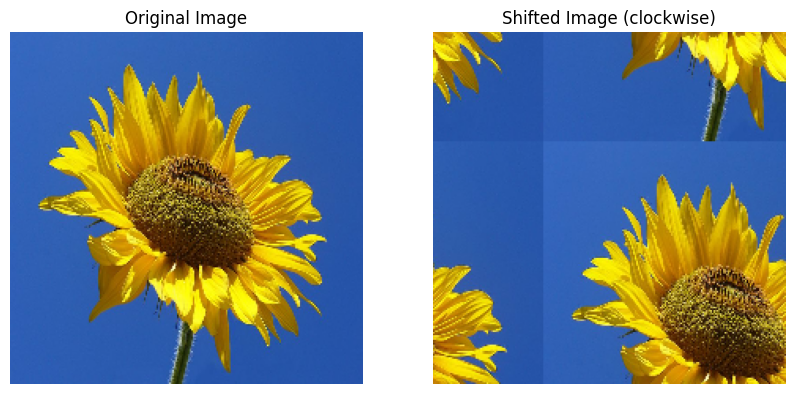

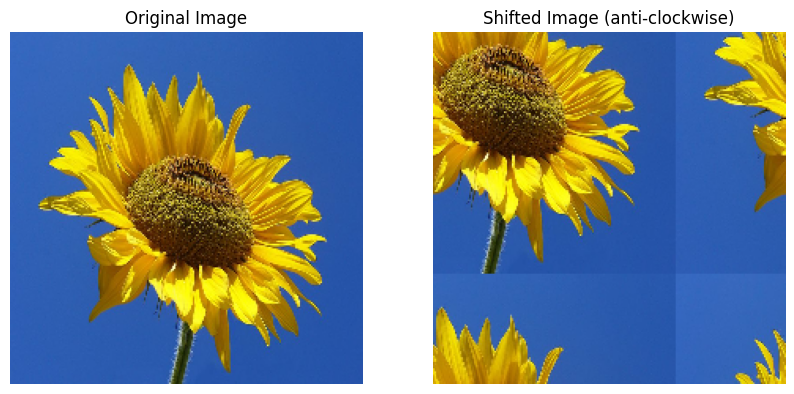

In [18]:
# Visualize shifted window operation on an image
image_path = "/content/sample_data/flower.jpg"  # Replace with actual image file path
visualize_shifted_window(image_path, window_size=70, shift_direction="clockwise")
visualize_shifted_window(image_path, window_size=70, shift_direction="anti-clockwise")